# Machine Learning

Este notebook apresenta o pipeline completo de *Machine Learning* para previsão do nível do rio a partir de dados hidrológicos e meteorológicos. O objetivo é construir, treinar e avaliar modelos capazes de prever eventos críticos, como enchentes, utilizando séries temporais.

> **Resumo das etapas:**
> - Pré-processamento dos dados
> - Criação de conjuntos de treino, validação e teste
> - Definição e treinamento de modelos (MLP, LSTM, GRU)
> - Otimização de hiperparâmetros
> - Avaliação e visualização dos resultados
> - Conclusão e próximos passos


## 1. Initial Setup

Esta seção realiza a configuração inicial do ambiente para o experimento de *Machine Learning*.

- **Definição de variáveis e hiperparâmetros:** Estabelece limites e parâmetros para o treinamento dos modelos, como número máximo de épocas e configurações do Optuna.
- **Importação de bibliotecas:** Carrega todas as dependências necessárias para manipulação de dados, visualização, modelagem e otimização.
- **Carregamento do dataset:** Importa os dados já pré-processados, prontos para uso nos modelos.

> *Certifique-se de que todas as bibliotecas estejam instaladas e que o dataset esteja disponível no caminho especificado.*


In [1]:
# Max allowable epochs for each model type
MAX_EPOCHS = 2000

# Hyperparameters for Hyperparameter Optimization using Optuna
OPTUNA_N_JOBS = 8  # Number of parallel jobs for hyperparameter optimization - controls how many trials run simultaneously
OPTUNA_N_TRIALS = 30  # Total number of optimization trials to run - more trials generally lead to better hyperparameter discovery
OPTUNA_PRUNE_N_STARTUP_TRIALS = 8  # Number of random trials before pruning starts - ensures diverse exploration before early stopping
OPTUNA_PRUNE_WARMUP_STEPS = 8  # Number of steps to wait before pruning can occur - prevents premature termination of promising trials

In [2]:
# Python native libraries
from typing import List, Dict, Any, Tuple
import warnings
import uuid
import random
import json

# Data manipulation and preprocessing
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# Visualization libraries
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# PyTorch libraries and derivatives
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import lightning as L
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping
from lightning.pytorch.loggers import TensorBoardLogger
from torchinfo import summary

# Optuna Libraries
import optuna
from optuna.integration import PyTorchLightningPruningCallback

# Add the parent directory to the system path to import custom modules
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
db_path = os.path.abspath(os.path.join(os.getcwd(), "..", "db"))
if db_path not in sys.path:
    sys.path.append(db_path)

# Set precision for matrix multiplication in order to optimize performance
torch.set_float32_matmul_precision("high")

# Set random seed for reproducibility
L.seed_everything(42)

/home/bruno/anaconda3/envs/fiap/lib/python3.11/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(
Seed set to 42


42

In [3]:
from data_process import load_and_process_data_from_db

df = load_and_process_data_from_db(start_date="2014-01-01", end_date="2024-12-31")
df.index = pd.to_datetime(df.index)
df.head()

,rain_upstream_mean,rain_upstream_max,rain_upstream_min,rain_upstream_q25,rain_upstream_q75,flow_upstream_mean,flow_upstream_max,flow_upstream_min,flow_upstream_q25,flow_upstream_q75,...,level_after_q75,rain_upstream_acc_2_days,rain_downstream_acc_2_days,rain_after_acc_2_days,rain_upstream_acc_3_days,rain_downstream_acc_3_days,rain_after_acc_3_days,date_sin,date_cos,year
date,,,,,,,,,,,,,,,,,,,,,
2014-01-01 00:00:00+00:00,0.000000,0.0,0.0,0.0,0.0,19.369072,20.1,18.3,18.8,19.8,...,291.0,0.000000,0.010309,0.0,0.000000,0.173196,0.0,0.000000,1.000000,2014
2014-01-02 00:00:00+00:00,0.004124,0.2,0.0,0.0,0.0,20.271134,21.0,19.3,19.8,20.6,...,308.0,0.004124,0.084536,0.0,0.004124,0.092784,0.0,0.017213,0.999852,2014
2014-01-03 00:00:00+00:00,0.000000,0.0,0.0,0.0,0.0,20.906383,22.3,19.3,19.8,22.1,...,302.0,0.004124,0.082474,0.0,0.004124,0.084536,0.0,0.034422,0.999407,2014
2014-01-04 00:00:00+00:00,0.000000,0.0,0.0,0.0,0.0,17.985567,19.8,16.7,17.4,18.3,...,280.0,0.000000,0.000000,0.0,0.004124,0.082474,0.0,0.051620,0.998667,2014
2014-01-05 00:00:00+00:00,0.000000,0.0,0.0,0.0,0.0,15.802128,16.7,15.0,15.5,16.0,...,271.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.068802,0.997630,2014


## 2. Data Preprocessing

Esta etapa prepara os dados para o treinamento dos modelos, garantindo qualidade e consistência.

- **Verificação de dados nulos:** Identifica e trata possíveis valores ausentes, evitando problemas durante o treinamento.
- **Remoção de colunas de vazão:** Exclui variáveis altamente correlacionadas (como `flow`), reduzindo redundância e evitando *overfitting*.
- **Normalização:** Aplica normalização para padronizar as escalas das variáveis, o que é fundamental para o bom desempenho de modelos baseados em gradiente.

> *O pré-processamento é essencial para garantir que os modelos aprendam padrões reais e não ruídos ou vieses dos dados.*


In [4]:
# Count missing values in each column
def print_missing_values(data):
    missing_values = data.isnull().sum()
    print("Missing values in each column:")
    print(missing_values[missing_values > 0])


print_missing_values(df)

Missing values in each column:
Series([], dtype: int64)


In [5]:
# Remove columns containing 'flow' from the dataframe
df = df.loc[:, ~df.columns.str.contains("flow")]
df.head()

,rain_upstream_mean,rain_upstream_max,rain_upstream_min,rain_upstream_q25,rain_upstream_q75,level_upstream_mean,level_upstream_max,level_upstream_min,level_upstream_q25,level_upstream_q75,...,level_after_q75,rain_upstream_acc_2_days,rain_downstream_acc_2_days,rain_after_acc_2_days,rain_upstream_acc_3_days,rain_downstream_acc_3_days,rain_after_acc_3_days,date_sin,date_cos,year
date,,,,,,,,,,,,,,,,,,,,,
2014-01-01 00:00:00+00:00,0.000000,0.0,0.0,0.0,0.0,219.154639,222.0,215.0,217.0,221.0,...,291.0,0.000000,0.010309,0.0,0.000000,0.173196,0.0,0.000000,1.000000,2014
2014-01-02 00:00:00+00:00,0.004124,0.2,0.0,0.0,0.0,222.835052,226.0,219.0,221.0,224.0,...,308.0,0.004124,0.084536,0.0,0.004124,0.092784,0.0,0.017213,0.999852,2014
2014-01-03 00:00:00+00:00,0.000000,0.0,0.0,0.0,0.0,225.361702,231.0,219.0,221.0,230.0,...,302.0,0.004124,0.082474,0.0,0.004124,0.084536,0.0,0.034422,0.999407,2014
2014-01-04 00:00:00+00:00,0.000000,0.0,0.0,0.0,0.0,213.515464,221.0,208.0,211.0,215.0,...,280.0,0.000000,0.000000,0.0,0.004124,0.082474,0.0,0.051620,0.998667,2014
2014-01-05 00:00:00+00:00,0.000000,0.0,0.0,0.0,0.0,204.287234,208.0,201.0,203.0,205.0,...,271.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.068802,0.997630,2014


In [6]:
scaler = StandardScaler()
# Normalize all columns except 'date_sin' and 'date_cos' (if present)
cols_to_normalize = [col for col in df.columns if col not in ["date_sin", "date_cos"]]
df_normalized = df.copy()
df_normalized[cols_to_normalize] = scaler.fit_transform(df[cols_to_normalize])
df_normalized.head()

,rain_upstream_mean,rain_upstream_max,rain_upstream_min,rain_upstream_q25,rain_upstream_q75,level_upstream_mean,level_upstream_max,level_upstream_min,level_upstream_q25,level_upstream_q75,...,level_after_q75,rain_upstream_acc_2_days,rain_downstream_acc_2_days,rain_after_acc_2_days,rain_upstream_acc_3_days,rain_downstream_acc_3_days,rain_after_acc_3_days,date_sin,date_cos,year
date,,,,,,,,,,,,,,,,,,,,,
2014-01-01 00:00:00+00:00,-0.350271,-0.347976,0.0,0.0,-0.114026,0.246097,0.072853,0.357251,0.310160,0.184338,...,0.679508,-0.452088,-0.411050,-0.35211,-0.514793,0.202644,-0.398491,0.000000,1.000000,-1.581277
2014-01-02 00:00:00+00:00,-0.309183,-0.294987,0.0,0.0,-0.114026,0.298787,0.124662,0.417361,0.368409,0.226006,...,0.854706,-0.425572,0.004581,-0.35211,-0.494664,-0.139441,-0.398491,0.017213,0.999852,-1.581277
2014-01-03 00:00:00+00:00,-0.350271,-0.347976,0.0,0.0,-0.114026,0.334959,0.189423,0.417361,0.368409,0.309341,...,0.792872,-0.425572,-0.006964,-0.35211,-0.494664,-0.174526,-0.398491,0.034422,0.999407,-1.581277
2014-01-04 00:00:00+00:00,-0.350271,-0.347976,0.0,0.0,-0.114026,0.165366,0.059901,0.252058,0.222785,0.101003,...,0.566145,-0.452088,-0.468777,-0.35211,-0.494664,-0.183298,-0.398491,0.051620,0.998667,-1.581277
2014-01-05 00:00:00+00:00,-0.350271,-0.347976,0.0,0.0,-0.114026,0.033253,-0.108478,0.146866,0.106285,-0.037890,...,0.473393,-0.452088,-0.468777,-0.35211,-0.514793,-0.534154,-0.398491,0.068802,0.997630,-1.581277


## 3. Criação dos Datasets

Aqui são definidos os conjuntos de dados para treino, validação e teste, utilizando uma abordagem de *chunking* aleatório.

> *Essa estratégia melhora a generalização dos modelos e simula cenários reais de produção, onde padrões podem variar ao longo do tempo.*

**Vantagens do chunking:**
- Diversifica os contextos temporais em cada split
- Reduz o risco de especialização em um único regime temporal
- Mantém a dependência temporal essencial para séries temporais


**Sobre a divisão dos dados:**

Neste projeto, utilizamos a divisão dos dados por *chunking* aleatório com split sequencial dentro de cada chunk, em vez do split sequencial tradicional. Veja abaixo a diferença entre as abordagens:

- **Chunking aleatório + split sequencial (utilizado aqui):**
  - Os dados são divididos em blocos (chunks) de tamanho aleatório.
  - Cada chunk é separado sequencialmente em treino, validação e teste.
  - Isso garante que cada split contenha diferentes padrões temporais, regimes e sazonalidades.

- **Split sequencial tradicional:**
  - Os dados são divididos em três blocos contínuos: início para treino, meio para validação e fim para teste.
  - Eventos raros ou mudanças de regime podem ficar concentrados em apenas um split, dificultando a generalização.

> **Neste projeto, utilizamos o método de chunking aleatório, pois ele proporciona maior diversidade e robustez na avaliação dos modelos.**

**Vantagens de cada abordagem:**

| Estratégia                   | Vantagens principais                                                                 |
|------------------------------|-----------------------------------------------------------------------------------|
| Chunking aleatório           | Diversidade de padrões em todos os splits, simula cenários reais, melhor generalização |
| Split sequencial tradicional | Simples de implementar, reflete cenários de previsão futura, mas pode ser enviesado  |

---

**Visualização esquemática:**

Split Sequencial Tradicional:

Treino      | Validação | Teste
------------|-----------|---------
████████████|████████|████████

Chunking Aleatório + Split Sequencial (utilizado):

| Chunk 1 |   |   | Chunk 2 |   |   | ... |
|--------------|--------------|--------------|--------------|--------------|--------------|------|
| Treino | Validação | Teste | Treino | Validação | Teste | ... |
|████████████|████████|████████|████████████|████████|████████| ... |

Legenda: Cada 3 colunas representam um chunk, e dentro de cada chunk há blocos de treino, validação e teste (Treino | Validação | Teste).

*No split tradicional, cada split é um bloco contínuo. No chunking, cada chunk contém amostras de treino, validação e teste, promovendo diversidade em todos os splits.*

> *A escolha do chunking aleatório permite que o modelo aprenda e seja avaliado em diferentes contextos temporais, tornando-o mais robusto para aplicações reais.*

In [7]:
class TimeSeriesDataset(Dataset):
    def __init__(self, data, sequence_length=24, target_col="level_downstream_max"):
        self.data = data.reset_index(drop=True)
        self.sequence_length = sequence_length
        self.target_col = self.data.columns.get_loc(target_col)

    def __len__(self):
        return len(self.data) - self.sequence_length

    def __getitem__(self, idx):
        x = self.data.iloc[
            idx : idx + self.sequence_length
        ].values  # (sequence_length, num_features)
        # Label is the value of target_col for the next day after the sequence
        y = self.data.iloc[idx + self.sequence_length, self.target_col]  # next day
        return torch.tensor(x, dtype=torch.float32), torch.tensor(
            y, dtype=torch.float32
        )


class NonOverlappingConcatDataset(Dataset):
    def __init__(self, datasets):
        self.datasets = datasets
        self.cumulative_lengths = []
        total = 0
        for d in datasets:
            self.cumulative_lengths.append(total)
            total += len(d)
        self.total_length = total

    def __len__(self):
        return self.total_length

    def __getitem__(self, idx):
        # Find which dataset this idx belongs to
        for i in range(len(self.datasets)):
            if idx < self.cumulative_lengths[i] + len(self.datasets[i]):
                local_idx = idx - self.cumulative_lengths[i]
                return self.datasets[i][local_idx]
        raise IndexError("Index out of range")


def split_train_validation_test(
    data: pd.DataFrame, train_size: float = 0.6, val_size: float = 0.2
):
    train_end = int(len(data) * train_size)
    val_end = int(len(data) * (train_size + val_size))

    train_data = data.iloc[:train_end]
    val_data = data.iloc[train_end:val_end]
    test_data = data.iloc[val_end:]

    return train_data, val_data, test_data


def create_datasets(
    sequence_length: int,
    min_chunk_size: int = 24,
    max_chunk_size: int = 100,
) -> Tuple[
    NonOverlappingConcatDataset,
    NonOverlappingConcatDataset,
    NonOverlappingConcatDataset,
]:
    import random

    datasets_train: List[TimeSeriesDataset] = []
    datasets_validation: List[TimeSeriesDataset] = []
    datasets_test: List[TimeSeriesDataset] = []

    data = df_normalized.reset_index(drop=True)
    n = len(data)
    idx = 0
    chunk_indices = []

    # Generate random chunk indices
    while idx < n:
        chunk_size = random.randint(min_chunk_size, max_chunk_size)
        if idx + chunk_size >= n:
            # Last chunk
            if n - idx < min_chunk_size:
                break  # Discard last chunk if too small
            chunk_indices.append((idx, n))
            break
        else:
            chunk_indices.append((idx, idx + chunk_size))
            idx += chunk_size

    for start, end in chunk_indices:
        chunk = data.iloc[start:end].reset_index(drop=True)
        if not chunk.empty:
            train_data, validation_data, test_data = split_train_validation_test(chunk)
            if (
                len(train_data) > sequence_length
                and len(validation_data) > sequence_length
                and len(test_data) > sequence_length
            ):
                datasets_train.append(
                    TimeSeriesDataset(train_data, sequence_length=sequence_length)
                )
                datasets_validation.append(
                    TimeSeriesDataset(validation_data, sequence_length=sequence_length)
                )
                datasets_test.append(
                    TimeSeriesDataset(test_data, sequence_length=sequence_length)
                )

    train_dataset = NonOverlappingConcatDataset(datasets_train)
    validation_dataset = NonOverlappingConcatDataset(datasets_validation)
    test_dataset = NonOverlappingConcatDataset(datasets_test)

    return train_dataset, validation_dataset, test_dataset


# Debugging example
# fake_train, fake_validation, fake_test = create_datasets(
#     sequence_length=2,
# )  # Example with sequence length of 2

# print(fake_train[0][1])
# fake_train[0][0].shape, fake_train[0][1].shape  # Should be (2, num_features), scalar

In [8]:
# Test for TimeSeriesDataset

# Create a simple DataFrame with increasing integers
test_df = pd.DataFrame({"A": np.arange(10)})

# Window length = 3
ts_dataset = TimeSeriesDataset(test_df, sequence_length=3, target_col="A")

print("Testing TimeSeriesDataset:")
for i in range(len(ts_dataset)):
    x, y = ts_dataset[i]
    print(f"Index {i}: x = {x.squeeze().numpy()}, y = {y.numpy()}")

# Test for NonOverlappingConcatDataset
# Create two small TimeSeriesDatasets
df1 = pd.DataFrame({"A": np.arange(5)})
df2 = pd.DataFrame({"A": np.arange(10, 15)})

ds1 = TimeSeriesDataset(df1, sequence_length=2, target_col="A")
ds2 = TimeSeriesDataset(df2, sequence_length=2, target_col="A")

print(df1)
print(df2)

concat_ds = NonOverlappingConcatDataset([ds1, ds2])

print("\nTesting NonOverlappingConcatDataset")
print("Should not overlap and should concatenate correctly:")
for i in range(len(concat_ds)):
    x, y = concat_ds[i]
    print(f"Index {i}: x = {x.squeeze().numpy()}, y = {y.numpy()}")

Testing TimeSeriesDataset:
Index 0: x = [0. 1. 2.], y = 3.0
Index 1: x = [1. 2. 3.], y = 4.0
Index 2: x = [2. 3. 4.], y = 5.0
Index 3: x = [3. 4. 5.], y = 6.0
Index 4: x = [4. 5. 6.], y = 7.0
Index 5: x = [5. 6. 7.], y = 8.0
Index 6: x = [6. 7. 8.], y = 9.0
   A
0  0
1  1
2  2
3  3
4  4
    A
0  10
1  11
2  12
3  13
4  14

Testing NonOverlappingConcatDataset
Should not overlap and should concatenate correctly:
Index 0: x = [0. 1.], y = 2.0
Index 1: x = [1. 2.], y = 3.0
Index 2: x = [2. 3.], y = 4.0
Index 3: x = [10. 11.], y = 12.0
Index 4: x = [11. 12.], y = 13.0
Index 5: x = [12. 13.], y = 14.0


## 4. Definição dos Modelos

Nesta etapa são definidos os modelos de *Machine Learning* utilizados para previsão:

- **MLP (Perceptron Multicamadas):** Modelo denso tradicional, útil como baseline para séries temporais.
- **LSTM (Long Short-Term Memory):** Rede neural recorrente especializada em capturar dependências de longo prazo em séries temporais.
- **GRU (Gated Recurrent Unit):** Variante mais simples e eficiente da LSTM, também indicada para séries temporais.

Cada modelo é implementado utilizando o framework PyTorch Lightning, facilitando o treinamento, validação e integração com callbacks e loggers.

> *A escolha de diferentes arquiteturas permite comparar desempenho e identificar a abordagem mais adequada para o problema.*


In [9]:
class MLP(L.LightningModule):
    def __init__(
        self,
        input_size,
        hidden_layers,
        learning_rate: float = 0.0001,
    ):
        super(MLP, self).__init__()
        self.save_hyperparameters()

        # MLP para cada passo temporal
        layers = []
        in_features = input_size
        for hidden_size in hidden_layers:
            layers.append(nn.Linear(in_features, hidden_size))
            layers.append(nn.ReLU())
            in_features = hidden_size
        self.step_mlp = nn.Sequential(*layers)
        self.final_layer = nn.Linear(in_features, 1)
        self.criterion = nn.MSELoss()

    def forward(self, x):
        # x: (batch, window_length, input_size)
        # Aplica o MLP em cada passo temporal    print("x type:", type(x))
        batch, window, features = x.shape
        x = x.view(-1, features)  # (batch * window_length, input_size)
        out = self.step_mlp(x)  # (batch * window_length, hidden)
        out = out.view(batch, window, -1)  # (batch, window_length, hidden)
        out = out.mean(dim=1)  # (batch, hidden) - agregação temporal
        out = self.final_layer(out)  # (batch, input_size)
        return out.squeeze(-1)  # (batch,)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.log("train_loss", loss)
        return loss

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=self.hparams.learning_rate)

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.log("val_loss", loss)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.log("test_loss", loss)
        return loss


class LSTM(L.LightningModule):
    def __init__(
        self,
        input_size,
        hidden_size,
        num_layers,
        learning_rate: float = 0.0001,
    ):
        super(LSTM, self).__init__()
        self.save_hyperparameters()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
        self.criterion = nn.MSELoss()

    def forward(self, x):
        out, _ = self.lstm(x)  # (batch, sequence_length, hidden_size)
        return self.fc(out[:, -1, :]).squeeze(-1)  # (batch,)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.log("train_loss", loss)
        return loss

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=self.hparams.learning_rate)

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.log("val_loss", loss)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.log("test_loss", loss)
        return loss


class GRU(L.LightningModule):
    def __init__(
        self,
        input_size,
        hidden_size,
        num_layers,
        learning_rate: float = 0.0001,
    ):
        super(GRU, self).__init__()
        self.save_hyperparameters()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
        self.criterion = nn.MSELoss()

    def forward(self, x):
        out, _ = self.gru(x)
        return self.fc(out[:, -1, :]).squeeze(-1)  # (batch,)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.log("train_loss", loss)
        return loss

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=self.hparams.learning_rate)

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.log("val_loss", loss)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.log("test_loss", loss)
        return loss


print(summary(MLP(input_size=5, hidden_layers=[10, 10])))
print("\n")
print(summary(LSTM(input_size=5, hidden_size=10, num_layers=2)))
print("\n")
print(summary(GRU(input_size=5, hidden_size=10, num_layers=2)))

Layer (type:depth-idx)                   Param #
MLP                                      --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       60
│    └─ReLU: 2-2                         --
│    └─Linear: 2-3                       110
│    └─ReLU: 2-4                         --
├─Linear: 1-2                            11
├─MSELoss: 1-3                           --
Total params: 181
Trainable params: 181
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
LSTM                                     --
├─LSTM: 1-1                              1,560
├─Linear: 1-2                            11
├─MSELoss: 1-3                           --
Total params: 1,571
Trainable params: 1,571
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
GRU                                      --
├─GRU: 1-1                               1,170
├─Linear: 1-2                            11
├─MSELoss: 1-3                           --
Total 

## 5. Treinamento dos Modelos

Esta seção abrange todo o processo de treinamento, validação e otimização dos modelos.

- **Funções de treinamento:** Automatizam o processo de treino, validação e avaliação dos modelos, utilizando *callbacks* para checkpoint e early stopping.
- **Otimização de hiperparâmetros:** Utiliza o Optuna para encontrar as melhores configurações de cada modelo, acelerando o processo com paralelismo e pruning.
- **Laço de treinamento:** Executa o treinamento final dos modelos com os melhores hiperparâmetros encontrados.

> *O uso de automação e otimização garante experimentos reprodutíveis e eficientes.*


### 5.1. Funções de treinamento

As funções desta subseção são responsáveis por:

- Treinar os modelos com os dados de treino e validação
- Avaliar o desempenho nos dados de teste
- Gerenciar logs, checkpoints e callbacks

> *Utilize estas funções para garantir um fluxo de treinamento padronizado e monitorado.*


In [10]:
def train_model(
    model,
    train_data,
    val_data,
    logger,
    epochs,
    batch_size,
    callbacks=[],
    verbose=True,
) -> None:
    """
    Treina o modelo com os dados de treino e validação.
    """

    train_loader = DataLoader(
        train_data, batch_size=batch_size, shuffle=True, drop_last=True
    )
    validation_loader = DataLoader(
        val_data, batch_size=4, shuffle=False, drop_last=True
    )

    trainer = Trainer(
        max_epochs=epochs,
        accelerator="auto",
        devices=1,
        logger=logger,
        enable_progress_bar=verbose,
        log_every_n_steps=1,
        callbacks=callbacks,
        deterministic=True,
        check_val_every_n_epoch=1,
        enable_model_summary=verbose,
    )
    trainer.fit(model, train_loader, validation_loader)


def evaluate_model(model, test_data, logger, batch_size=4):
    """
    Avalia o modelo com os dados de teste.
    """
    print("\nEvaluating model. Using the test dataset.")
    test_loader = DataLoader(
        test_data, batch_size=batch_size, shuffle=False, drop_last=True
    )

    trainer = Trainer(
        accelerator="auto",
        devices=1,
        logger=logger,
        enable_progress_bar=True,
        deterministic=True,
    )
    trainer.test(model, test_loader)


def save_model_and_hyperparams(
    model,
    model_class,
    model_kwargs,
    train_kwargs,
    input_size=None,
    sequence_length=None,
):
    """
    Save the model state dict and hyperparameters to the models/ directory.
    Ensures sequence_length and input_size são sempre salvos como parte dos hiperparâmetros.
    """
    model_type = model_class.__name__.lower()
    models_dir = os.path.join(os.getcwd(), "..", "models")
    os.makedirs(models_dir, exist_ok=True)
    pt_path = os.path.join(models_dir, f"{model_type}.pt")
    torch.save(model.state_dict(), pt_path)
    hyperparams = dict(model_kwargs)
    hyperparams.update(train_kwargs)
    hyperparams["model_type"] = model_class.__name__
    # Always save sequence_length if provided
    if sequence_length is not None:
        hyperparams["sequence_length"] = sequence_length
    # Always save input_size
    hyperparams["input_size"] = input_size
    json_path = os.path.join(models_dir, f"{model_type}_hyperparams.json")
    with open(json_path, "w") as f:
        json.dump(hyperparams, f, indent=2)


def run_experiment(
    model_class: type[L.LightningModule],
    name: str,
    model_kwargs: Dict[str, Any] = {},
    train_kwargs: Dict[str, Any] = {},
    evaluate: bool = True,
    extra_callbacks: List[L.Callback] = [],
    verbose: bool = True,
    id: str = "",
    save_path: str = "",
):
    """
    Executa um experimento de treinamento e avaliação do modelo.
    """
    # Logger
    logger = TensorBoardLogger(save_dir=os.getcwd(), name=f"lightning_logs/{name}")

    checkpoint_callback = ModelCheckpoint(
        monitor="val_loss", mode="min", save_top_k=1, filename=f"best_model_{id}"
    )

    early_stopping_callback = EarlyStopping(
        monitor="val_loss",
        min_delta=1e-4,
        patience=10,
        mode="min",
        strict=False,
    )

    train_dataset, validation_dataset, test_dataset = create_datasets(
        sequence_length=train_kwargs.get("sequence_length", 5)
    )

    # Remove 'sequence_length' from train_kwargs if present
    train_kwargs = dict(train_kwargs)  # make a copy to avoid side effects
    sequence_length = train_kwargs.pop("sequence_length", None)

    input_size = train_dataset[0][0].shape[1]  # Assuming all inputs have the same shape

    model = model_class(input_size=input_size, **(model_kwargs or {}))

    train_model(
        model,
        train_dataset,
        validation_dataset,
        logger=logger,
        **(train_kwargs or {}),
        callbacks=[checkpoint_callback, early_stopping_callback, *extra_callbacks],
        verbose=verbose,
    )

    best_validation_loss = checkpoint_callback.best_model_score
    best_model_path = checkpoint_callback.best_model_path

    # To view the logs, you can use TensorBoard.
    # If 'logs' is a SummaryWriter, get its log_dir and launch TensorBoard:
    print(f"To view logs, run in terminal:\n  tensorboard --logdir {logger.log_dir}")
    print("Best model saved at:", best_model_path)

    if evaluate:
        best_model = model_class.load_from_checkpoint(best_model_path, **model_kwargs)
        evaluate_model(best_model, test_dataset, logger, batch_size=4)

    if save_path:
        save_model_and_hyperparams(
            best_model,
            model_class,
            model_kwargs,
            train_kwargs,
            input_size=input_size,
            sequence_length=sequence_length,
        )

    return {
        "best_validation_loss": (
            best_validation_loss.item() if best_validation_loss is not None else None
        ),
        "best_model_path": best_model_path,
    }

### 5.2. Funções de otimização de hiperparâmetros

Esta subseção implementa a busca automática pelos melhores hiperparâmetros dos modelos utilizando o Optuna.

- **Definição do espaço de busca:** Cada modelo possui um conjunto de hiperparâmetros a serem otimizados (ex: número de camadas, taxa de aprendizado, tamanho da janela temporal).
- **Função objetivo:** Avalia o desempenho do modelo para cada combinação de hiperparâmetros.
- **Execução dos experimentos:** Roda múltiplos experimentos em paralelo, utilizando pruning para acelerar a busca.

> *A otimização de hiperparâmetros é fundamental para extrair o máximo desempenho dos modelos.*


In [11]:
def get_optimization_args(model_class: L.LightningModule, trial):
    """
    Retorna os argumentos necessários para executar o experimento.
    """
    if model_class == MLP:
        model_kwargs = {
            "hidden_layers": trial.suggest_categorical(
                "hidden_layers",
                (
                    [32, 16],
                    [48, 24],
                    [64, 32],
                    [96, 48],
                    [128, 64],
                    [64, 32, 16],
                    [128, 64, 32],
                ),
            ),
            "learning_rate": trial.suggest_float("learning_rate", 1e-5, 1e-3, log=True),
        }
        train_kwargs = {
            "epochs": MAX_EPOCHS,
            "batch_size": trial.suggest_int("batch_size", 2, 32),
            "sequence_length": trial.suggest_int("sequence_length", 2, 15),
        }
    elif model_class == LSTM:
        model_kwargs = {
            "hidden_size": trial.suggest_int("hidden_size", 16, 128),
            "num_layers": trial.suggest_int("num_layers", 1, 3),
            "learning_rate": trial.suggest_float("learning_rate", 1e-7, 1e-3, log=True),
        }
        train_kwargs = {
            "epochs": MAX_EPOCHS,
            "batch_size": trial.suggest_int("batch_size", 2, 32),
            "sequence_length": trial.suggest_int("sequence_length", 2, 15),
        }
    elif model_class == GRU:
        model_kwargs = {
            "hidden_size": trial.suggest_int("hidden_size", 16, 128),
            "num_layers": trial.suggest_int("num_layers", 1, 3),
            "learning_rate": trial.suggest_float("learning_rate", 1e-7, 1e-3, log=True),
        }
        train_kwargs = {
            "epochs": MAX_EPOCHS,
            "batch_size": trial.suggest_int("batch_size", 8, 32),
            "sequence_length": trial.suggest_int("sequence_length", 3, 12),
        }
    else:
        raise ValueError(f"Unsupported model class: {model_class}")
    return model_kwargs, train_kwargs


def get_objective_fn(model_class, name):
    """
    Retorna uma função de objetivo para otimização de hiperparâmetros.
    """

    def objective(trial: optuna.trial.Trial) -> float:
        # Ajusta os hiperparâmetros com base no trial
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=UserWarning)
            model_kwargs, train_kwargs = get_optimization_args(model_class, trial)

        optuna_pruning_callback = PyTorchLightningPruningCallback(
            trial, monitor="val_loss"
        )

        results = run_experiment(
            model_class=model_class,
            name=name,
            model_kwargs=model_kwargs,
            train_kwargs=train_kwargs,
            evaluate=False,
            extra_callbacks=[optuna_pruning_callback],
            verbose=False,
            id=uuid.uuid4().hex[:8],
        )
        return results["best_validation_loss"]

    return objective


def run_optimization(objective_fn, n_trials=OPTUNA_N_TRIALS) -> optuna.study.Study:
    pruner = optuna.pruners.MedianPruner(
        n_startup_trials=OPTUNA_PRUNE_N_STARTUP_TRIALS,
        n_warmup_steps=OPTUNA_PRUNE_WARMUP_STEPS,
    )
    study = optuna.create_study(direction="minimize", pruner=pruner)
    study.optimize(
        objective_fn, n_trials=n_trials, n_jobs=OPTUNA_N_JOBS, show_progress_bar=True
    )

    print("Best trial:")
    trial = study.best_trial
    print(f"  Value: {trial.value}")
    print("  Params: ")
    for key, value in trial.params.items():
        print(f"    {key}: {value}")

    return study

### 5.3. Laço de treinamento final

Aqui são executados os treinamentos finais dos modelos MLP, LSTM e GRU utilizando os melhores hiperparâmetros encontrados na etapa anterior.

- **Treinamento final:** Cada modelo é treinado do zero com os hiperparâmetros otimizados.
- **Avaliação:** O desempenho é avaliado nos dados de teste, permitindo comparação justa entre as arquiteturas.

> *Os resultados obtidos aqui servirão de base para análise e conclusões posteriores.*


In [12]:
mlp_objective_fn = get_objective_fn(
    MLP,
    "mlp",
)

study_mlp = run_optimization(mlp_objective_fn, n_trials=OPTUNA_N_TRIALS)

mlp_optimized_results = run_experiment(
    MLP,
    "mlp_optimized",
    model_kwargs={
        "hidden_layers": study_mlp.best_trial.params["hidden_layers"],
        "learning_rate": study_mlp.best_trial.params["learning_rate"],
    },
    train_kwargs={
        "epochs": MAX_EPOCHS,
        "batch_size": study_mlp.best_trial.params["batch_size"],
        "sequence_length": study_mlp.best_trial.params["sequence_length"],
    },
    evaluate=True,
    verbose=True,
    save_path="../models/mlp_optimized.pt",
)

print("\nMLP Optimized Results:", mlp_optimized_results)

[I 2025-06-06 20:52:57,091] A new study created in memory with name: no-name-d0b27554-22ad-457d-8499-96404830e0f4


  0%|          | 0/30 [00:00<?, ?it/s]

GPU available: True (cuda), used: True
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
GPU available: True (cuda), used: True
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
TPU available: False, using: 0 TPU cores
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
GPU available: True (cuda), used: True
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
TPU available: False, using: 0 TPU cores
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
HPU available: False, using: 0 HPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025-06-06 20:52:57.558722: I tensorflow/core/util/port.cc:110] oneDNN c

To view logs, run in terminal:
  tensorboard --logdir /home/bruno/Workspace/FIAP/2025/gs-disaster/ml/lightning_logs/mlp/version_0
Best model saved at: /home/bruno/Workspace/FIAP/2025/gs-disaster/ml/lightning_logs/mlp/version_0/checkpoints/best_model_d933baea.ckpt
[I 2025-06-06 20:53:28,350] Trial 1 finished with value: 0.5005029439926147 and parameters: {'hidden_layers': [96, 48], 'learning_rate': 0.00045703591622380473, 'batch_size': 27, 'sequence_length': 11}. Best is trial 1 with value: 0.5005029439926147.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/bruno/anaconda3/envs/fiap/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/home/bruno/anaconda3/envs/fiap/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


To view logs, run in terminal:
  tensorboard --logdir /home/bruno/Workspace/FIAP/2025/gs-disaster/ml/lightning_logs/mlp/version_0
Best model saved at: /home/bruno/Workspace/FIAP/2025/gs-disaster/ml/lightning_logs/mlp/version_0/checkpoints/best_model_a928d19a.ckpt
[I 2025-06-06 20:53:34,568] Trial 7 finished with value: 0.408329576253891 and parameters: {'hidden_layers': [48, 24], 'learning_rate': 0.00032560005276925457, 'batch_size': 15, 'sequence_length': 15}. Best is trial 7 with value: 0.408329576253891.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/bruno/anaconda3/envs/fiap/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/home/bruno/anaconda3/envs/fiap/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


To view logs, run in terminal:
  tensorboard --logdir /home/bruno/Workspace/FIAP/2025/gs-disaster/ml/lightning_logs/mlp/version_1
Best model saved at: /home/bruno/Workspace/FIAP/2025/gs-disaster/ml/lightning_logs/mlp/version_1/checkpoints/best_model_e488e66d.ckpt
[I 2025-06-06 20:54:09,999] Trial 8 finished with value: 0.6149502992630005 and parameters: {'hidden_layers': [64, 32], 'learning_rate': 0.0006426256369138749, 'batch_size': 31, 'sequence_length': 12}. Best is trial 7 with value: 0.408329576253891.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/bruno/anaconda3/envs/fiap/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/home/bruno/anaconda3/envs/fiap/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


To view logs, run in terminal:
  tensorboard --logdir /home/bruno/Workspace/FIAP/2025/gs-disaster/ml/lightning_logs/mlp/version_0
Best model saved at: /home/bruno/Workspace/FIAP/2025/gs-disaster/ml/lightning_logs/mlp/version_0/checkpoints/best_model_d0803962.ckpt
[I 2025-06-06 20:54:30,529] Trial 6 finished with value: 0.5020662546157837 and parameters: {'hidden_layers': [64, 32], 'learning_rate': 0.0007135701283944955, 'batch_size': 15, 'sequence_length': 7}. Best is trial 7 with value: 0.408329576253891.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/bruno/anaconda3/envs/fiap/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/home/bruno/anaconda3/envs/fiap/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


To view logs, run in terminal:
  tensorboard --logdir /home/bruno/Workspace/FIAP/2025/gs-disaster/ml/lightning_logs/mlp/version_0
Best model saved at: /home/bruno/Workspace/FIAP/2025/gs-disaster/ml/lightning_logs/mlp/version_0/checkpoints/best_model_2ffb45a2.ckpt
[I 2025-06-06 20:54:35,079] Trial 5 finished with value: 0.4278852939605713 and parameters: {'hidden_layers': [64, 32, 16], 'learning_rate': 0.00037789946557961556, 'batch_size': 20, 'sequence_length': 15}. Best is trial 7 with value: 0.408329576253891.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/bruno/anaconda3/envs/fiap/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/home/bruno/anaconda3/envs/fiap/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


To view logs, run in terminal:
  tensorboard --logdir /home/bruno/Workspace/FIAP/2025/gs-disaster/ml/lightning_logs/mlp/version_0
Best model saved at: /home/bruno/Workspace/FIAP/2025/gs-disaster/ml/lightning_logs/mlp/version_0/checkpoints/best_model_3ec5fe53.ckpt
[I 2025-06-06 20:54:38,423] Trial 0 finished with value: 0.5002886652946472 and parameters: {'hidden_layers': [96, 48], 'learning_rate': 0.0003383190269227053, 'batch_size': 21, 'sequence_length': 14}. Best is trial 7 with value: 0.408329576253891.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/bruno/anaconda3/envs/fiap/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/home/bruno/anaconda3/envs/fiap/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


To view logs, run in terminal:
  tensorboard --logdir /home/bruno/Workspace/FIAP/2025/gs-disaster/ml/lightning_logs/mlp/version_0
Best model saved at: /home/bruno/Workspace/FIAP/2025/gs-disaster/ml/lightning_logs/mlp/version_0/checkpoints/best_model_511df46d.ckpt
[I 2025-06-06 20:54:58,908] Trial 2 finished with value: 0.23269517719745636 and parameters: {'hidden_layers': [48, 24], 'learning_rate': 3.3758533588773085e-05, 'batch_size': 18, 'sequence_length': 10}. Best is trial 2 with value: 0.23269517719745636.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/bruno/anaconda3/envs/fiap/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/home/bruno/anaconda3/envs/fiap/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


To view logs, run in terminal:
  tensorboard --logdir /home/bruno/Workspace/FIAP/2025/gs-disaster/ml/lightning_logs/mlp/version_0
Best model saved at: /home/bruno/Workspace/FIAP/2025/gs-disaster/ml/lightning_logs/mlp/version_0/checkpoints/best_model_7728aaf2.ckpt
[I 2025-06-06 20:55:23,971] Trial 3 finished with value: 0.4849857687950134 and parameters: {'hidden_layers': [96, 48], 'learning_rate': 0.0001419626931206184, 'batch_size': 12, 'sequence_length': 10}. Best is trial 2 with value: 0.23269517719745636.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/bruno/anaconda3/envs/fiap/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/home/bruno/anaconda3/envs/fiap/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


[I 2025-06-06 20:55:56,174] Trial 9 pruned. Trial was pruned at epoch 14.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/bruno/anaconda3/envs/fiap/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/home/bruno/anaconda3/envs/fiap/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


[I 2025-06-06 20:56:15,217] Trial 11 pruned. Trial was pruned at epoch 8.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/bruno/anaconda3/envs/fiap/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/home/bruno/anaconda3/envs/fiap/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


To view logs, run in terminal:
  tensorboard --logdir /home/bruno/Workspace/FIAP/2025/gs-disaster/ml/lightning_logs/mlp/version_8
Best model saved at: /home/bruno/Workspace/FIAP/2025/gs-disaster/ml/lightning_logs/mlp/version_8/checkpoints/best_model_148bdeac.ckpt
[I 2025-06-06 20:56:29,474] Trial 15 finished with value: 0.42682063579559326 and parameters: {'hidden_layers': [32, 16], 'learning_rate': 0.0003229367257911702, 'batch_size': 22, 'sequence_length': 10}. Best is trial 2 with value: 0.23269517719745636.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/bruno/anaconda3/envs/fiap/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/home/bruno/anaconda3/envs/fiap/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


To view logs, run in terminal:
  tensorboard --logdir /home/bruno/Workspace/FIAP/2025/gs-disaster/ml/lightning_logs/mlp/version_0
Best model saved at: /home/bruno/Workspace/FIAP/2025/gs-disaster/ml/lightning_logs/mlp/version_0/checkpoints/best_model_cca82955.ckpt
[I 2025-06-06 20:56:49,423] Trial 4 finished with value: 0.35161590576171875 and parameters: {'hidden_layers': [64, 32, 16], 'learning_rate': 5.338269160370197e-05, 'batch_size': 27, 'sequence_length': 10}. Best is trial 2 with value: 0.23269517719745636.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/bruno/anaconda3/envs/fiap/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/home/bruno/anaconda3/envs/fiap/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


[I 2025-06-06 20:57:29,239] Trial 17 pruned. Trial was pruned at epoch 8.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/bruno/anaconda3/envs/fiap/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/home/bruno/anaconda3/envs/fiap/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


[I 2025-06-06 20:57:57,375] Trial 18 pruned. Trial was pruned at epoch 8.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/bruno/anaconda3/envs/fiap/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/home/bruno/anaconda3/envs/fiap/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


[I 2025-06-06 20:58:07,142] Trial 19 pruned. Trial was pruned at epoch 8.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/bruno/anaconda3/envs/fiap/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/home/bruno/anaconda3/envs/fiap/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


[I 2025-06-06 20:58:16,165] Trial 20 pruned. Trial was pruned at epoch 8.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/bruno/anaconda3/envs/fiap/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/home/bruno/anaconda3/envs/fiap/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


[I 2025-06-06 20:58:29,595] Trial 10 pruned. Trial was pruned at epoch 56.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/bruno/anaconda3/envs/fiap/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/home/bruno/anaconda3/envs/fiap/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


[I 2025-06-06 20:58:45,304] Trial 21 pruned. Trial was pruned at epoch 8.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/bruno/anaconda3/envs/fiap/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/home/bruno/anaconda3/envs/fiap/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


To view logs, run in terminal:
  tensorboard --logdir /home/bruno/Workspace/FIAP/2025/gs-disaster/ml/lightning_logs/mlp/version_7
Best model saved at: /home/bruno/Workspace/FIAP/2025/gs-disaster/ml/lightning_logs/mlp/version_7/checkpoints/best_model_2b1f12b2.ckpt
[I 2025-06-06 20:58:55,516] Trial 14 finished with value: 0.3921211063861847 and parameters: {'hidden_layers': [96, 48], 'learning_rate': 0.00037312422679065295, 'batch_size': 10, 'sequence_length': 6}. Best is trial 2 with value: 0.23269517719745636.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/bruno/anaconda3/envs/fiap/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/home/bruno/anaconda3/envs/fiap/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


To view logs, run in terminal:
  tensorboard --logdir /home/bruno/Workspace/FIAP/2025/gs-disaster/ml/lightning_logs/mlp/version_5
Best model saved at: /home/bruno/Workspace/FIAP/2025/gs-disaster/ml/lightning_logs/mlp/version_5/checkpoints/best_model_271f8844.ckpt
[I 2025-06-06 20:59:15,101] Trial 12 finished with value: 0.33117881417274475 and parameters: {'hidden_layers': [128, 64, 32], 'learning_rate': 3.6523685093025606e-05, 'batch_size': 19, 'sequence_length': 7}. Best is trial 2 with value: 0.23269517719745636.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/bruno/anaconda3/envs/fiap/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/home/bruno/anaconda3/envs/fiap/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


[I 2025-06-06 20:59:33,442] Trial 24 pruned. Trial was pruned at epoch 8.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/bruno/anaconda3/envs/fiap/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/home/bruno/anaconda3/envs/fiap/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


To view logs, run in terminal:
  tensorboard --logdir /home/bruno/Workspace/FIAP/2025/gs-disaster/ml/lightning_logs/mlp/version_6
Best model saved at: /home/bruno/Workspace/FIAP/2025/gs-disaster/ml/lightning_logs/mlp/version_6/checkpoints/best_model_78b8dd69.ckpt
[I 2025-06-06 20:59:34,363] Trial 13 finished with value: 0.3612895905971527 and parameters: {'hidden_layers': [96, 48], 'learning_rate': 0.0003710079759478819, 'batch_size': 12, 'sequence_length': 6}. Best is trial 2 with value: 0.23269517719745636.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/bruno/anaconda3/envs/fiap/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/home/bruno/anaconda3/envs/fiap/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


[I 2025-06-06 20:59:42,004] Trial 16 pruned. Trial was pruned at epoch 15.
[I 2025-06-06 21:00:14,139] Trial 23 pruned. Trial was pruned at epoch 8.
[I 2025-06-06 21:00:24,138] Trial 29 pruned. Trial was pruned at epoch 8.
[I 2025-06-06 21:00:26,430] Trial 28 pruned. Trial was pruned at epoch 8.
[I 2025-06-06 21:00:44,081] Trial 22 pruned. Trial was pruned at epoch 31.
[I 2025-06-06 21:00:52,704] Trial 26 pruned. Trial was pruned at epoch 31.
To view logs, run in terminal:
  tensorboard --logdir /home/bruno/Workspace/FIAP/2025/gs-disaster/ml/lightning_logs/mlp/version_18
Best model saved at: /home/bruno/Workspace/FIAP/2025/gs-disaster/ml/lightning_logs/mlp/version_18/checkpoints/best_model_39e14df9.ckpt
[I 2025-06-06 21:01:26,847] Trial 25 finished with value: 0.35928022861480713 and parameters: {'hidden_layers': [128, 64, 32], 'learning_rate': 7.805047730848153e-05, 'batch_size': 7, 'sequence_length': 6}. Best is trial 2 with value: 0.23269517719745636.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type       | Params | Mode 
---------------------------------------------------
0 | step_mlp    | Sequential | 3.1 K  | train
1 | final_layer | Linear     | 25     | train
2 | criterion   | MSELoss    | 0      | train
---------------------------------------------------
3.1 K     Trainable params
0         Non-trainable params
3.1 K     Total params
0.012     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


To view logs, run in terminal:
  tensorboard --logdir /home/bruno/Workspace/FIAP/2025/gs-disaster/ml/lightning_logs/mlp/version_20
Best model saved at: /home/bruno/Workspace/FIAP/2025/gs-disaster/ml/lightning_logs/mlp/version_20/checkpoints/best_model_12ee61dd.ckpt
[I 2025-06-06 21:02:47,508] Trial 27 finished with value: 0.29490143060684204 and parameters: {'hidden_layers': [128, 64, 32], 'learning_rate': 1.9783061677042373e-05, 'batch_size': 19, 'sequence_length': 6}. Best is trial 2 with value: 0.23269517719745636.
Best trial:
  Value: 0.23269517719745636
  Params: 
    hidden_layers: [48, 24]
    learning_rate: 3.3758533588773085e-05
    batch_size: 18
    sequence_length: 10


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

To view logs, run in terminal:
  tensorboard --logdir /home/bruno/Workspace/FIAP/2025/gs-disaster/ml/lightning_logs/mlp_optimized/version_0
Best model saved at: /home/bruno/Workspace/FIAP/2025/gs-disaster/ml/lightning_logs/mlp_optimized/version_0/checkpoints/best_model_.ckpt


Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Evaluating model. Using the test dataset.


/home/bruno/anaconda3/envs/fiap/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.5768747925758362     │
└───────────────────────────┴───────────────────────────┘


MLP Optimized Results: {'best_validation_loss': 0.4165627956390381, 'best_model_path': '/home/bruno/Workspace/FIAP/2025/gs-disaster/ml/lightning_logs/mlp_optimized/version_0/checkpoints/best_model_.ckpt'}


In [13]:
lstm_objective_fn = get_objective_fn(
    LSTM,
    "lstm",
)
study_lstm = run_optimization(lstm_objective_fn, n_trials=OPTUNA_N_TRIALS)
lstm_optimized_results = run_experiment(
    LSTM,
    "lstm_optimized",
    model_kwargs={
        "hidden_size": study_lstm.best_trial.params["hidden_size"],
        "num_layers": study_lstm.best_trial.params["num_layers"],
        "learning_rate": study_lstm.best_trial.params["learning_rate"],
    },
    train_kwargs={
        "epochs": MAX_EPOCHS,
        "batch_size": study_lstm.best_trial.params["batch_size"],
    },
    evaluate=True,
    verbose=True,
    save_path="../models/lstm_optimized.pt",
)
print("\nLSTM Optimized Results:", lstm_optimized_results)

[I 2025-06-06 21:03:39,965] A new study created in memory with name: no-name-93940b61-9da7-4283-9385-335020ec16bd


  0%|          | 0/30 [00:00<?, ?it/s]

GPU available: True (cuda), used: True
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
GPU available: True (cuda), used: True
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
TPU available: False, using: 0 TPU cores
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
GPU available: True (cuda), used: True
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
TPU available: False, using: 0 TPU cores
TPU available: False, using: 0 TPU cores
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
HPU available: Fal

To view logs, run in terminal:
  tensorboard --logdir /home/bruno/Workspace/FIAP/2025/gs-disaster/ml/lightning_logs/lstm/version_3
Best model saved at: /home/bruno/Workspace/FIAP/2025/gs-disaster/ml/lightning_logs/lstm/version_3/checkpoints/best_model_ac92f029.ckpt
[I 2025-06-06 21:04:57,556] Trial 6 finished with value: 0.33421042561531067 and parameters: {'hidden_size': 37, 'num_layers': 3, 'learning_rate': 0.00046402482034256813, 'batch_size': 30, 'sequence_length': 10}. Best is trial 6 with value: 0.33421042561531067.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/bruno/anaconda3/envs/fiap/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/home/bruno/anaconda3/envs/fiap/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


To view logs, run in terminal:
  tensorboard --logdir /home/bruno/Workspace/FIAP/2025/gs-disaster/ml/lightning_logs/lstm/version_5
Best model saved at: /home/bruno/Workspace/FIAP/2025/gs-disaster/ml/lightning_logs/lstm/version_5/checkpoints/best_model_f874392c.ckpt
[I 2025-06-06 21:10:47,915] Trial 1 finished with value: 0.3985406756401062 and parameters: {'hidden_size': 29, 'num_layers': 3, 'learning_rate': 4.8892131752540314e-05, 'batch_size': 16, 'sequence_length': 12}. Best is trial 6 with value: 0.33421042561531067.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/bruno/anaconda3/envs/fiap/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/home/bruno/anaconda3/envs/fiap/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


To view logs, run in terminal:
  tensorboard --logdir /home/bruno/Workspace/FIAP/2025/gs-disaster/ml/lightning_logs/lstm/version_2
Best model saved at: /home/bruno/Workspace/FIAP/2025/gs-disaster/ml/lightning_logs/lstm/version_2/checkpoints/best_model_77f1df8b.ckpt
[I 2025-06-06 21:12:48,143] Trial 7 finished with value: 0.4512673020362854 and parameters: {'hidden_size': 64, 'num_layers': 3, 'learning_rate': 1.5059913003928515e-05, 'batch_size': 28, 'sequence_length': 13}. Best is trial 6 with value: 0.33421042561531067.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/bruno/anaconda3/envs/fiap/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/home/bruno/anaconda3/envs/fiap/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


To view logs, run in terminal:
  tensorboard --logdir /home/bruno/Workspace/FIAP/2025/gs-disaster/ml/lightning_logs/lstm/version_4
Best model saved at: /home/bruno/Workspace/FIAP/2025/gs-disaster/ml/lightning_logs/lstm/version_4/checkpoints/best_model_88f3cbb7.ckpt
[I 2025-06-06 21:15:05,397] Trial 3 finished with value: 0.26571956276893616 and parameters: {'hidden_size': 81, 'num_layers': 3, 'learning_rate': 1.6554847948152782e-05, 'batch_size': 13, 'sequence_length': 8}. Best is trial 3 with value: 0.26571956276893616.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/bruno/anaconda3/envs/fiap/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/home/bruno/anaconda3/envs/fiap/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


To view logs, run in terminal:
  tensorboard --logdir /home/bruno/Workspace/FIAP/2025/gs-disaster/ml/lightning_logs/lstm/version_6
Best model saved at: /home/bruno/Workspace/FIAP/2025/gs-disaster/ml/lightning_logs/lstm/version_6/checkpoints/best_model_62473e99.ckpt
[I 2025-06-06 21:16:27,185] Trial 8 finished with value: 0.34299373626708984 and parameters: {'hidden_size': 125, 'num_layers': 3, 'learning_rate': 1.6633690110235496e-05, 'batch_size': 23, 'sequence_length': 7}. Best is trial 3 with value: 0.26571956276893616.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/bruno/anaconda3/envs/fiap/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/home/bruno/anaconda3/envs/fiap/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


To view logs, run in terminal:
  tensorboard --logdir /home/bruno/Workspace/FIAP/2025/gs-disaster/ml/lightning_logs/lstm/version_10
Best model saved at: /home/bruno/Workspace/FIAP/2025/gs-disaster/ml/lightning_logs/lstm/version_10/checkpoints/best_model_a6343398.ckpt
[I 2025-06-06 21:44:00,667] Trial 12 finished with value: 0.36083394289016724 and parameters: {'hidden_size': 91, 'num_layers': 3, 'learning_rate': 8.618822295928544e-06, 'batch_size': 6, 'sequence_length': 6}. Best is trial 3 with value: 0.26571956276893616.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/bruno/anaconda3/envs/fiap/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/home/bruno/anaconda3/envs/fiap/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


To view logs, run in terminal:
  tensorboard --logdir /home/bruno/Workspace/FIAP/2025/gs-disaster/ml/lightning_logs/lstm/version_7
Best model saved at: /home/bruno/Workspace/FIAP/2025/gs-disaster/ml/lightning_logs/lstm/version_7/checkpoints/best_model_e5aed158.ckpt
[I 2025-06-06 21:45:33,208] Trial 9 finished with value: 0.10060055553913116 and parameters: {'hidden_size': 32, 'num_layers': 1, 'learning_rate': 6.256170744947498e-07, 'batch_size': 29, 'sequence_length': 15}. Best is trial 9 with value: 0.10060055553913116.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/bruno/anaconda3/envs/fiap/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/home/bruno/anaconda3/envs/fiap/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


To view logs, run in terminal:
  tensorboard --logdir /home/bruno/Workspace/FIAP/2025/gs-disaster/ml/lightning_logs/lstm/version_12
Best model saved at: /home/bruno/Workspace/FIAP/2025/gs-disaster/ml/lightning_logs/lstm/version_12/checkpoints/best_model_d89f1417.ckpt
[I 2025-06-06 21:46:44,147] Trial 14 finished with value: 0.3850211203098297 and parameters: {'hidden_size': 51, 'num_layers': 1, 'learning_rate': 0.0003487251404749827, 'batch_size': 13, 'sequence_length': 14}. Best is trial 9 with value: 0.10060055553913116.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/bruno/anaconda3/envs/fiap/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/home/bruno/anaconda3/envs/fiap/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


[I 2025-06-06 21:46:44,982] Trial 13 pruned. Trial was pruned at epoch 19.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/bruno/anaconda3/envs/fiap/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/home/bruno/anaconda3/envs/fiap/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


[I 2025-06-06 21:46:46,391] Trial 0 pruned. Trial was pruned at epoch 1586.
[I 2025-06-06 21:46:46,620] Trial 2 pruned. Trial was pruned at epoch 542.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/bruno/anaconda3/envs/fiap/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/home/bruno/anaconda3/envs/fiap/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-06-06 21:46:51,125] Trial 5 pruned. Trial was pruned at epoch 441.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/bruno/anaconda3/envs/fiap/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/home/bruno/anaconda3/envs/fiap/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


[I 2025-06-06 21:47:06,000] Trial 15 pruned. Trial was pruned at epoch 10.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/bruno/anaconda3/envs/fiap/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/home/bruno/anaconda3/envs/fiap/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


[I 2025-06-06 21:47:50,913] Trial 17 pruned. Trial was pruned at epoch 8.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/bruno/anaconda3/envs/fiap/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/home/bruno/anaconda3/envs/fiap/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


[I 2025-06-06 21:48:01,331] Trial 20 pruned. Trial was pruned at epoch 8.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/bruno/anaconda3/envs/fiap/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/home/bruno/anaconda3/envs/fiap/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


[I 2025-06-06 21:48:38,085] Trial 21 pruned. Trial was pruned at epoch 8.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/bruno/anaconda3/envs/fiap/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/home/bruno/anaconda3/envs/fiap/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


[I 2025-06-06 21:48:50,671] Trial 18 pruned. Trial was pruned at epoch 8.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/bruno/anaconda3/envs/fiap/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/home/bruno/anaconda3/envs/fiap/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


To view logs, run in terminal:
  tensorboard --logdir /home/bruno/Workspace/FIAP/2025/gs-disaster/ml/lightning_logs/lstm/version_14
Best model saved at: /home/bruno/Workspace/FIAP/2025/gs-disaster/ml/lightning_logs/lstm/version_14/checkpoints/best_model_176df3c0.ckpt
[I 2025-06-06 21:49:45,917] Trial 16 finished with value: 0.3630637228488922 and parameters: {'hidden_size': 42, 'num_layers': 2, 'learning_rate': 0.00013956342086271007, 'batch_size': 16, 'sequence_length': 5}. Best is trial 9 with value: 0.10060055553913116.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/bruno/anaconda3/envs/fiap/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/home/bruno/anaconda3/envs/fiap/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


[I 2025-06-06 21:50:06,370] Trial 4 pruned. Trial was pruned at epoch 589.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/bruno/anaconda3/envs/fiap/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/home/bruno/anaconda3/envs/fiap/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


[I 2025-06-06 21:50:32,940] Trial 10 pruned. Trial was pruned at epoch 578.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/bruno/anaconda3/envs/fiap/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/home/bruno/anaconda3/envs/fiap/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


[I 2025-06-06 21:50:47,322] Trial 26 pruned. Trial was pruned at epoch 8.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/bruno/anaconda3/envs/fiap/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/home/bruno/anaconda3/envs/fiap/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


To view logs, run in terminal:
  tensorboard --logdir /home/bruno/Workspace/FIAP/2025/gs-disaster/ml/lightning_logs/lstm/version_21
Best model saved at: /home/bruno/Workspace/FIAP/2025/gs-disaster/ml/lightning_logs/lstm/version_21/checkpoints/best_model_2d20a9c2.ckpt
[I 2025-06-06 21:50:57,537] Trial 23 finished with value: 0.30964013934135437 and parameters: {'hidden_size': 73, 'num_layers': 2, 'learning_rate': 8.24333465181357e-05, 'batch_size': 19, 'sequence_length': 5}. Best is trial 9 with value: 0.10060055553913116.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/bruno/anaconda3/envs/fiap/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/home/bruno/anaconda3/envs/fiap/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


[I 2025-06-06 21:51:00,932] Trial 22 pruned. Trial was pruned at epoch 8.
To view logs, run in terminal:
  tensorboard --logdir /home/bruno/Workspace/FIAP/2025/gs-disaster/ml/lightning_logs/lstm/version_17
Best model saved at: /home/bruno/Workspace/FIAP/2025/gs-disaster/ml/lightning_logs/lstm/version_17/checkpoints/best_model_e29eeea3.ckpt
[I 2025-06-06 21:51:17,421] Trial 19 finished with value: 0.39272186160087585 and parameters: {'hidden_size': 89, 'num_layers': 1, 'learning_rate': 7.22639144350577e-05, 'batch_size': 8, 'sequence_length': 10}. Best is trial 9 with value: 0.10060055553913116.
To view logs, run in terminal:
  tensorboard --logdir /home/bruno/Workspace/FIAP/2025/gs-disaster/ml/lightning_logs/lstm/version_22
Best model saved at: /home/bruno/Workspace/FIAP/2025/gs-disaster/ml/lightning_logs/lstm/version_22/checkpoints/best_model_4cc483a9.ckpt
[I 2025-06-06 21:51:27,975] Trial 24 finished with value: 0.37259870767593384 and parameters: {'hidden_size': 67, 'num_layers': 2,

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | lstm      | LSTM    | 9.3 K  | train
1 | fc        | Linear  | 33     | train
2 | criterion | MSELoss | 0      | train
----------------------------------------------
9.4 K     Trainable params
0         Non-trainable params
9.4 K     Total params
0.038     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode


[I 2025-06-06 21:54:54,775] Trial 11 pruned. Trial was pruned at epoch 515.
Best trial:
  Value: 0.10060055553913116
  Params: 
    hidden_size: 32
    num_layers: 1
    learning_rate: 6.256170744947498e-07
    batch_size: 29
    sequence_length: 15


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=2000` reached.
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.


To view logs, run in terminal:
  tensorboard --logdir /home/bruno/Workspace/FIAP/2025/gs-disaster/ml/lightning_logs/lstm_optimized/version_0
Best model saved at: /home/bruno/Workspace/FIAP/2025/gs-disaster/ml/lightning_logs/lstm_optimized/version_0/checkpoints/best_model_.ckpt

Evaluating model. Using the test dataset.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/bruno/anaconda3/envs/fiap/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.3665051758289337     │
└───────────────────────────┴───────────────────────────┘


LSTM Optimized Results: {'best_validation_loss': 0.39817923307418823, 'best_model_path': '/home/bruno/Workspace/FIAP/2025/gs-disaster/ml/lightning_logs/lstm_optimized/version_0/checkpoints/best_model_.ckpt'}


In [14]:
gru_objective_fn = get_objective_fn(
    GRU,
    "gru",
)
study_gru = run_optimization(gru_objective_fn, n_trials=OPTUNA_N_TRIALS)
gru_optimized_results = run_experiment(
    GRU,
    "gru_optimized",
    model_kwargs={
        "hidden_size": study_gru.best_trial.params["hidden_size"],
        "num_layers": study_gru.best_trial.params["num_layers"],
        "learning_rate": study_gru.best_trial.params["learning_rate"],
    },
    train_kwargs={
        "epochs": MAX_EPOCHS,
        "batch_size": study_gru.best_trial.params["batch_size"],
    },
    evaluate=True,
    verbose=True,
    save_path="../models/gru_optimized.pt",
)
print("\nGRU Optimized Results:", gru_optimized_results)

[I 2025-06-06 22:28:37,147] A new study created in memory with name: no-name-72673008-5d8f-4d45-bd33-f29c007a1a83


  0%|          | 0/30 [00:00<?, ?it/s]

GPU available: True (cuda), used: True
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
GPU available: True (cuda), used: True
HPU available: False, using: 0 HPUs
TPU available: False, using: 0 TPU cores
GPU available: True (cuda), used: True
HPU available: False, using: 0 HPUs
TPU available: False, using: 0 TPU cores
GPU available: True (cuda), used: True
HPU available: False, using: 0 HPUs
TPU available: False, using: 0 TPU cores
GPU available: True (cuda), used: True
HPU available: False, using: 0 HPUs
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
HPU available: False, using: 0 HPUs
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VI

To view logs, run in terminal:
  tensorboard --logdir /home/bruno/Workspace/FIAP/2025/gs-disaster/ml/lightning_logs/gru/version_2
Best model saved at: /home/bruno/Workspace/FIAP/2025/gs-disaster/ml/lightning_logs/gru/version_2/checkpoints/best_model_309030b6.ckpt
[I 2025-06-06 22:29:29,644] Trial 1 finished with value: 0.1502157747745514 and parameters: {'hidden_size': 87, 'num_layers': 2, 'learning_rate': 0.00031465558958325575, 'batch_size': 25, 'sequence_length': 12}. Best is trial 1 with value: 0.1502157747745514.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


To view logs, run in terminal:
  tensorboard --logdir /home/bruno/Workspace/FIAP/2025/gs-disaster/ml/lightning_logs/gru/version_3
Best model saved at: /home/bruno/Workspace/FIAP/2025/gs-disaster/ml/lightning_logs/gru/version_3/checkpoints/best_model_da8bf12f.ckpt
[I 2025-06-06 22:29:56,055] Trial 2 finished with value: 0.26255160570144653 and parameters: {'hidden_size': 78, 'num_layers': 1, 'learning_rate': 0.00043237231448612035, 'batch_size': 26, 'sequence_length': 4}. Best is trial 1 with value: 0.1502157747745514.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


To view logs, run in terminal:
  tensorboard --logdir /home/bruno/Workspace/FIAP/2025/gs-disaster/ml/lightning_logs/gru/version_8
Best model saved at: /home/bruno/Workspace/FIAP/2025/gs-disaster/ml/lightning_logs/gru/version_8/checkpoints/best_model_c473445e.ckpt
[I 2025-06-06 22:31:29,590] Trial 9 finished with value: 0.39475876092910767 and parameters: {'hidden_size': 71, 'num_layers': 2, 'learning_rate': 8.350112033351436e-05, 'batch_size': 10, 'sequence_length': 10}. Best is trial 1 with value: 0.1502157747745514.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


To view logs, run in terminal:
  tensorboard --logdir /home/bruno/Workspace/FIAP/2025/gs-disaster/ml/lightning_logs/gru/version_6
Best model saved at: /home/bruno/Workspace/FIAP/2025/gs-disaster/ml/lightning_logs/gru/version_6/checkpoints/best_model_d36c5d63.ckpt
[I 2025-06-06 22:32:23,002] Trial 3 finished with value: 0.32464852929115295 and parameters: {'hidden_size': 95, 'num_layers': 1, 'learning_rate': 0.0001477890041061303, 'batch_size': 16, 'sequence_length': 3}. Best is trial 1 with value: 0.1502157747745514.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


To view logs, run in terminal:
  tensorboard --logdir /home/bruno/Workspace/FIAP/2025/gs-disaster/ml/lightning_logs/gru/version_10
Best model saved at: /home/bruno/Workspace/FIAP/2025/gs-disaster/ml/lightning_logs/gru/version_10/checkpoints/best_model_3065a262.ckpt
[I 2025-06-06 22:34:20,546] Trial 11 finished with value: 0.3207642138004303 and parameters: {'hidden_size': 94, 'num_layers': 1, 'learning_rate': 0.00020595328230259662, 'batch_size': 31, 'sequence_length': 10}. Best is trial 1 with value: 0.1502157747745514.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


To view logs, run in terminal:
  tensorboard --logdir /home/bruno/Workspace/FIAP/2025/gs-disaster/ml/lightning_logs/gru/version_5
Best model saved at: /home/bruno/Workspace/FIAP/2025/gs-disaster/ml/lightning_logs/gru/version_5/checkpoints/best_model_7a4b203e.ckpt
[I 2025-06-06 22:36:05,048] Trial 6 finished with value: 0.3289911150932312 and parameters: {'hidden_size': 103, 'num_layers': 2, 'learning_rate': 2.252699233059136e-05, 'batch_size': 25, 'sequence_length': 6}. Best is trial 1 with value: 0.1502157747745514.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


To view logs, run in terminal:
  tensorboard --logdir /home/bruno/Workspace/FIAP/2025/gs-disaster/ml/lightning_logs/gru/version_12
Best model saved at: /home/bruno/Workspace/FIAP/2025/gs-disaster/ml/lightning_logs/gru/version_12/checkpoints/best_model_eed039e1.ckpt
[I 2025-06-06 22:42:52,283] Trial 13 finished with value: 0.2478676289319992 and parameters: {'hidden_size': 96, 'num_layers': 1, 'learning_rate': 2.567213704201286e-05, 'batch_size': 8, 'sequence_length': 11}. Best is trial 1 with value: 0.1502157747745514.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


To view logs, run in terminal:
  tensorboard --logdir /home/bruno/Workspace/FIAP/2025/gs-disaster/ml/lightning_logs/gru/version_13
Best model saved at: /home/bruno/Workspace/FIAP/2025/gs-disaster/ml/lightning_logs/gru/version_13/checkpoints/best_model_1e3706fa.ckpt
[I 2025-06-06 22:44:37,315] Trial 14 finished with value: 0.2904771864414215 and parameters: {'hidden_size': 83, 'num_layers': 3, 'learning_rate': 0.0001886935649831308, 'batch_size': 19, 'sequence_length': 5}. Best is trial 1 with value: 0.1502157747745514.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-06-06 22:45:29,056] Trial 15 pruned. Trial was pruned at epoch 8.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-06-06 22:46:16,914] Trial 16 pruned. Trial was pruned at epoch 8.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-06-06 22:46:47,804] Trial 17 pruned. Trial was pruned at epoch 8.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


To view logs, run in terminal:
  tensorboard --logdir /home/bruno/Workspace/FIAP/2025/gs-disaster/ml/lightning_logs/gru/version_7
Best model saved at: /home/bruno/Workspace/FIAP/2025/gs-disaster/ml/lightning_logs/gru/version_7/checkpoints/best_model_61dc04fe.ckpt
[I 2025-06-06 22:46:53,995] Trial 8 finished with value: 0.33844172954559326 and parameters: {'hidden_size': 97, 'num_layers': 3, 'learning_rate': 4.7001607293405814e-06, 'batch_size': 23, 'sequence_length': 9}. Best is trial 1 with value: 0.1502157747745514.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-06-06 22:46:54,495] Trial 5 pruned. Trial was pruned at epoch 196.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-06-06 22:46:58,487] Trial 7 pruned. Trial was pruned at epoch 201.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-06-06 22:47:26,878] Trial 19 pruned. Trial was pruned at epoch 8.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-06-06 22:47:29,131] Trial 18 pruned. Trial was pruned at epoch 8.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


To view logs, run in terminal:
  tensorboard --logdir /home/bruno/Workspace/FIAP/2025/gs-disaster/ml/lightning_logs/gru/version_19
Best model saved at: /home/bruno/Workspace/FIAP/2025/gs-disaster/ml/lightning_logs/gru/version_19/checkpoints/best_model_2cbbf7bd.ckpt
[I 2025-06-06 22:47:51,574] Trial 20 finished with value: 0.32730284333229065 and parameters: {'hidden_size': 58, 'num_layers': 1, 'learning_rate': 0.0008477055053752814, 'batch_size': 8, 'sequence_length': 12}. Best is trial 1 with value: 0.1502157747745514.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


To view logs, run in terminal:
  tensorboard --logdir /home/bruno/Workspace/FIAP/2025/gs-disaster/ml/lightning_logs/gru/version_20
Best model saved at: /home/bruno/Workspace/FIAP/2025/gs-disaster/ml/lightning_logs/gru/version_20/checkpoints/best_model_9df655ce.ckpt
[I 2025-06-06 22:47:55,321] Trial 21 finished with value: 0.3127632439136505 and parameters: {'hidden_size': 59, 'num_layers': 2, 'learning_rate': 0.0008277535499721174, 'batch_size': 15, 'sequence_length': 12}. Best is trial 1 with value: 0.1502157747745514.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-06-06 22:48:01,157] Trial 22 pruned. Trial was pruned at epoch 8.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-06-06 22:48:25,437] Trial 25 pruned. Trial was pruned at epoch 8.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-06-06 22:48:29,059] Trial 24 pruned. Trial was pruned at epoch 8.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-06-06 22:48:30,098] Trial 26 pruned. Trial was pruned at epoch 8.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-06-06 22:48:53,415] Trial 27 pruned. Trial was pruned at epoch 8.
[I 2025-06-06 22:49:03,201] Trial 29 pruned. Trial was pruned at epoch 8.
To view logs, run in terminal:
  tensorboard --logdir /home/bruno/Workspace/FIAP/2025/gs-disaster/ml/lightning_logs/gru/version_27
Best model saved at: /home/bruno/Workspace/FIAP/2025/gs-disaster/ml/lightning_logs/gru/version_27/checkpoints/best_model_41c0225e.ckpt
[I 2025-06-06 22:49:57,105] Trial 28 finished with value: 0.3141602575778961 and parameters: {'hidden_size': 80, 'num_layers': 1, 'learning_rate': 0.0002577551245486097, 'batch_size': 27, 'sequence_length': 7}. Best is trial 1 with value: 0.1502157747745514.
To view logs, run in terminal:
  tensorboard --logdir /home/bruno/Workspace/FIAP/2025/gs-disaster/ml/lightning_logs/gru/version_22
Best model saved at: /home/bruno/Workspace/FIAP/2025/gs-disaster/ml/lightning_logs/gru/version_22/checkpoints/best_model_efc1f568.ckpt
[I 2025-06-06 22:50:00,720] Trial 23 finished with value: 0.2

`Trainer.fit` stopped: `max_epochs=2000` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | gru       | GRU     | 79.3 K | train
1 | fc        | Linear  | 88     | train
2 | criterion | MSELoss | 0      | train
----------------------------------------------
79.4 K    Trainable params
0         Non-trainable params
79.4 K    Total params
0.318     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode


To view logs, run in terminal:
  tensorboard --logdir /home/bruno/Workspace/FIAP/2025/gs-disaster/ml/lightning_logs/gru/version_0
Best model saved at: /home/bruno/Workspace/FIAP/2025/gs-disaster/ml/lightning_logs/gru/version_0/checkpoints/best_model_be5ef5f0.ckpt
[I 2025-06-06 23:04:33,794] Trial 4 finished with value: 0.42009100317955017 and parameters: {'hidden_size': 21, 'num_layers': 3, 'learning_rate': 1.818268480534701e-06, 'batch_size': 19, 'sequence_length': 12}. Best is trial 1 with value: 0.1502157747745514.
Best trial:
  Value: 0.1502157747745514
  Params: 
    hidden_size: 87
    num_layers: 2
    learning_rate: 0.00031465558958325575
    batch_size: 25
    sequence_length: 12


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


To view logs, run in terminal:
  tensorboard --logdir /home/bruno/Workspace/FIAP/2025/gs-disaster/ml/lightning_logs/gru_optimized/version_0
Best model saved at: /home/bruno/Workspace/FIAP/2025/gs-disaster/ml/lightning_logs/gru_optimized/version_0/checkpoints/best_model_.ckpt

Evaluating model. Using the test dataset.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.31602200865745544    │
└───────────────────────────┴───────────────────────────┘


GRU Optimized Results: {'best_validation_loss': 0.36490994691848755, 'best_model_path': '/home/bruno/Workspace/FIAP/2025/gs-disaster/ml/lightning_logs/gru_optimized/version_0/checkpoints/best_model_.ckpt'}


## 6. Avaliação dos Modelos

Esta etapa compara o desempenho dos modelos treinados, utilizando métricas quantitativas e visualizações gráficas.

- **Comparação visual:** Gráficos que mostram as previsões dos modelos versus os valores reais ao longo do tempo, destacando as regiões de treino, validação e teste.
- **Análise de desempenho:** Permite identificar padrões, tendências, possíveis overfits e diferenças de desempenho entre os modelos.

> *A avaliação visual é essencial para entender o comportamento dos modelos em diferentes cenários e períodos da série temporal.*


### 6.1. Visualização

Os gráficos desta subseção facilitam a análise comparativa entre as previsões dos modelos (MLP, LSTM, GRU) e os valores reais.

- **Cores de fundo:** Indicam os splits de treino, validação e teste.
- **Linhas:** Representam as previsões suavizadas de cada modelo e os valores reais.
- **Divisão em painéis:** Permite visualizar segmentos da série temporal de forma clara e organizada.

> *Com esta visualização, é possível identificar rapidamente regiões de bom ou mau desempenho, além de padrões sazonais ou eventos extremos.*

Project root resolved to: /home/bruno/Workspace/FIAP/2025/gs-disaster
Models path: /home/bruno/Workspace/FIAP/2025/gs-disaster/models


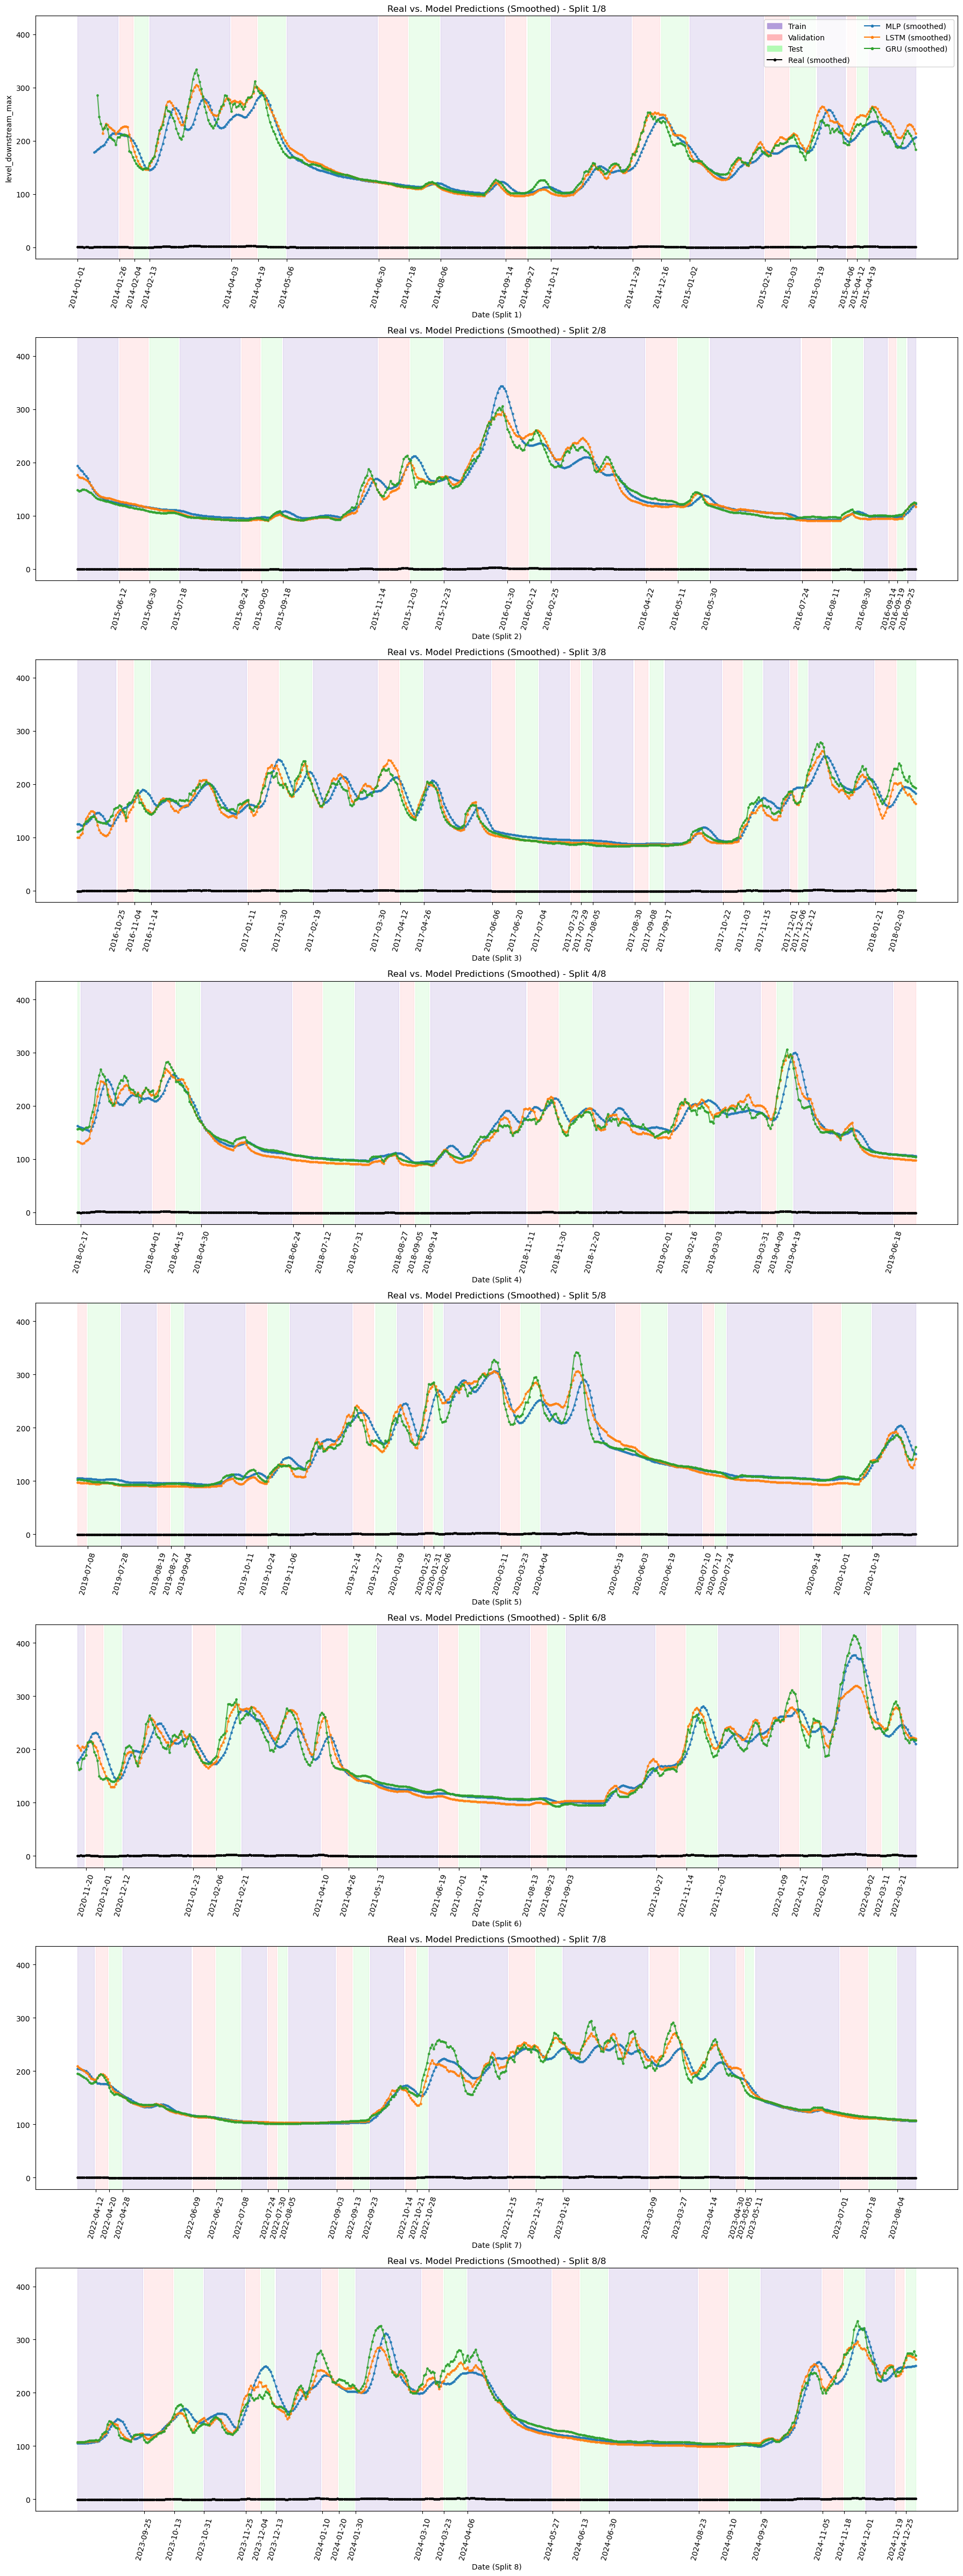

In [15]:
# --- 1. Define split colors and model colors ---
split_colors = {
    "train": "#b39ddb",  # stronger purple
    "validation": "#ffb6b9",  # stronger pink
    "test": "#b2fab4",  # stronger green
}
model_colors = {
    "Real": "black",
    "MLP": "tab:blue",
    "LSTM": "tab:orange",
    "GRU": "tab:green",
}


# --- 2. Recreate chunking and split mapping ---
def get_chunk_splits(data, sequence_length=5, min_chunk_size=24, max_chunk_size=100):
    n = len(data)
    idx = 0
    chunk_indices = []
    while idx < n:
        chunk_size = random.randint(min_chunk_size, max_chunk_size)
        if idx + chunk_size >= n:
            if n - idx < min_chunk_size:
                break
            chunk_indices.append((idx, n))
            break
        else:
            chunk_indices.append((idx, idx + chunk_size))
            idx += chunk_size

    split_map = {}
    chunk_boundaries = []
    chunk_labels = []
    for chunk_id, (start, end) in enumerate(chunk_indices):
        chunk_len = end - start
        train_end = start + int(chunk_len * 0.6)
        val_end = start + int(chunk_len * 0.8)
        # Assign split type for each index in chunk
        for i in range(start, train_end):
            split_map[i] = ("train", chunk_id)
        for i in range(train_end, val_end):
            split_map[i] = ("validation", chunk_id)
        for i in range(val_end, end):
            split_map[i] = ("test", chunk_id)
        chunk_boundaries.append((start, end))
        chunk_labels.append(f"Chunk {chunk_id}")
    return split_map, chunk_boundaries, chunk_labels


split_map, chunk_boundaries, chunk_labels = get_chunk_splits(
    df_normalized, sequence_length=5
)

# --- 3. Prepare data for plotting ---
x_labels = df_normalized.index  # Use date or index
target_col = "level_downstream_max"
real_values = df_normalized[target_col].values

# For each sample, get split type and chunk id
split_types = []
chunk_ids = []
for i in range(len(df_normalized)):
    split, chunk_id = split_map.get(i, ("none", -1))
    split_types.append(split)
    chunk_ids.append(chunk_id)


# --- 4. Prediction function for a model ---
def get_model_predictions(
    model, data, sequence_length, scaler=None, target_col="level_downstream_max"
):
    """
    Returns predictions in the original (unscaled) value for the target column.
    scaler: StandardScaler fitted on training data (required for denormalization)
    target_col: name of the target column
    """
    import numpy as np

    model.eval()
    preds = [None] * len(data)
    if scaler is None:
        from ml.ml_utils import get_scaler

        scaler = get_scaler()
    cols_to_normalize = [
        col for col in data.columns if col not in ["date_sin", "date_cos"]
    ]
    target_idx = data.columns.get_loc(target_col)
    with torch.no_grad():
        for i in range(len(data) - sequence_length):
            x = data.iloc[i : i + sequence_length].values
            x_tensor = torch.tensor(x, dtype=torch.float32).unsqueeze(0).to(device)
            y_pred_scaled = model(x_tensor).cpu().numpy().squeeze()
            # Denormalize prediction
            dummy = np.zeros((1, len(cols_to_normalize)))
            dummy[0, target_idx] = y_pred_scaled
            y_pred_unscaled = scaler.inverse_transform(dummy)[0, target_idx]
            preds[i + sequence_length] = y_pred_unscaled
    return preds


# Set the paths for the best models
mlp_checkpoint_path = mlp_optimized_results["best_model_path"]
lstm_checkpoint_path = lstm_optimized_results["best_model_path"]
gru_checkpoint_path = gru_optimized_results["best_model_path"]

device = "cuda" if torch.cuda.is_available() else "cpu"

# Load best models (replace with your checkpoint paths)
mlp_model = MLP.load_from_checkpoint(mlp_checkpoint_path).to(device)
lstm_model = LSTM.load_from_checkpoint(lstm_checkpoint_path).to(device)
gru_model = GRU.load_from_checkpoint(gru_checkpoint_path).to(device)

mlp_preds = get_model_predictions(
    mlp_model,
    df_normalized,
    sequence_length=study_mlp.best_trial.params["sequence_length"],
)
lstm_preds = get_model_predictions(
    lstm_model,
    df_normalized,
    sequence_length=study_lstm.best_trial.params["sequence_length"],
)
gru_preds = get_model_predictions(
    gru_model,
    df_normalized,
    sequence_length=study_gru.best_trial.params["sequence_length"],
)

# --- 5. Plotting with smoothing (split into 4 rows) ---
n_splits = 8
n_samples = len(real_values)
split_size = n_samples // n_splits

fig, axes = plt.subplots(
    nrows=n_splits, ncols=1, figsize=(18, 6 * n_splits), sharey=True
)

window = 7  # Smoothing window size (days/samples)

for split_idx in range(n_splits):
    ax = axes[split_idx]
    start_idx = split_idx * split_size
    end_idx = (split_idx + 1) * split_size if split_idx < n_splits - 1 else n_samples

    # Get the date indices for this split
    split_dates = x_labels[start_idx:end_idx]

    # For each sample in this split, shade background according to split type
    last_split = None
    region_start = 0
    for i in range(start_idx, end_idx):
        split = split_types[i]
        if split != last_split or i == end_idx - 1:
            if last_split is not None:
                region_end = i if split != last_split else i + 1
                color = split_colors.get(last_split, "#f0f0f0")
                # Use date indices for axvspan
                ax.axvspan(
                    split_dates[region_start - start_idx],
                    (
                        split_dates[region_end - start_idx - 1]
                        if region_end - start_idx - 1 < len(split_dates)
                        else split_dates[-1]
                    ),
                    color=color,
                    alpha=0.25,
                    zorder=0,
                )
            region_start = i
            last_split = split

    # Smooth real values for this split
    real_smooth = (
        pd.Series(real_values[start_idx:end_idx], index=split_dates)
        .rolling(window, min_periods=1)
        .mean()
    )
    ax.plot(
        split_dates,
        real_smooth,
        label="Real (smoothed)" if split_idx == 0 else None,
        color=model_colors["Real"],
        marker=".",
        markersize=5,
        linewidth=1.5,
        zorder=2,
    )

    # Plot smoothed model predictions (skip None values)
    for name, preds, color in [
        ("MLP", mlp_preds, model_colors["MLP"]),
        ("LSTM", lstm_preds, model_colors["LSTM"]),
        ("GRU", gru_preds, model_colors["GRU"]),
    ]:
        idxs = [i for i in range(start_idx, end_idx) if preds[i] is not None]
        vals = [preds[i] for i in idxs]
        if vals:
            idx_dates = [x_labels[i] for i in idxs]
            vals_smooth = (
                pd.Series(vals, index=idx_dates).rolling(window, min_periods=1).mean()
            )
            ax.plot(
                idx_dates,
                vals_smooth,
                label=f"{name} (smoothed)" if split_idx == 0 else None,
                color=color,
                marker=".",
                markersize=5,
                linewidth=1.5,
                alpha=0.8,
                zorder=3,
            )
    # X-axis ticks at chunk starts within this split (now using dates)
    split_tick_indices = []
    split_tick_labels = []
    for chunk_start, chunk_end in chunk_boundaries:
        # Only consider chunks that overlap with this split
        if chunk_end <= start_idx or chunk_start >= end_idx:
            continue
        chunk_len = chunk_end - chunk_start
        train_start = chunk_start
        val_start = chunk_start + int(chunk_len * 0.6)
        test_start = chunk_start + int(chunk_len * 0.8)
        for idx in [train_start, val_start, test_start]:
            if start_idx <= idx < end_idx:
                split_tick_indices.append(idx)
                split_tick_labels.append(str(x_labels[idx].date()))

    ax.set_xticks([x_labels[i] for i in split_tick_indices])
    ax.set_xticklabels(split_tick_labels, rotation=75)
    ax.set_xlabel(f"Date (Split {split_idx+1})")
    if split_idx == 0:
        ax.set_ylabel(target_col)
    ax.set_title(
        f"Real vs. Model Predictions (Smoothed) - Split {split_idx+1}/{n_splits}"
    )

# Legends for splits (background) and models (lines) only on the first subplot
split_patches = [
    mpatches.Patch(color=split_colors[k], label=k.capitalize()) for k in split_colors
]
model_lines = [
    plt.Line2D([0], [0], color=model_colors[k], marker=".", label=f"{k} (smoothed)")
    for k in model_colors
]
axes[0].legend(handles=split_patches + model_lines, loc="upper right", ncol=2)

plt.tight_layout()
plt.show()

## 7. Conclusões

*Espaço reservado para as conclusões finais após análise dos resultados dos modelos.*

> **Inclua aqui as principais descobertas, limitações e sugestões para trabalhos futuros.**


*Espaço reservado para métricas quantitativas (RMSE, MAE, etc.) e observações finais após o treinamento dos modelos.*


In [16]:
print("[DEBUG] Columns used for training (df_normalized):", list(df_normalized.columns))

[DEBUG] Columns used for training (df_normalized): ['rain_upstream_mean', 'rain_upstream_max', 'rain_upstream_min', 'rain_upstream_q25', 'rain_upstream_q75', 'level_upstream_mean', 'level_upstream_max', 'level_upstream_min', 'level_upstream_q25', 'level_upstream_q75', 'rain_downstream_mean', 'rain_downstream_max', 'rain_downstream_min', 'rain_downstream_q25', 'rain_downstream_q75', 'level_downstream_mean', 'level_downstream_max', 'level_downstream_min', 'level_downstream_q25', 'level_downstream_q75', 'rain_after_mean', 'rain_after_max', 'rain_after_min', 'rain_after_q25', 'rain_after_q75', 'level_after_mean', 'level_after_max', 'level_after_min', 'level_after_q25', 'level_after_q75', 'rain_upstream_acc_2_days', 'rain_downstream_acc_2_days', 'rain_after_acc_2_days', 'rain_upstream_acc_3_days', 'rain_downstream_acc_3_days', 'rain_after_acc_3_days', 'date_sin', 'date_cos', 'year']
